In [156]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import everygrams
from nltk.lm.preprocessing import padded_everygram_pipeline
from collections import Counter

from tensorflow.keras.utils import pad_sequences
from collections import Counter
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers = 8)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
df = pd.read_csv('../data/processed_data.csv')

In [4]:
sample_df = df.sample(frac=1).iloc[:].reset_index()
sample_df.drop(sample_df.columns[:-1], axis=1, inplace=True)
sample_df.head()

,preprocessed text
0,<bos> lowbudget film writer goes work london c...
1,<bos> loved movie scenery breathtaking plot ni...
2,<bos> march new york times article described c...
3,<bos> watched pretty damn awesome fights fanta...
4,<bos> cell fascinated first glance bit surpris...


In [5]:
n_grms = sample_df['preprocessed text'].parallel_apply(lambda a: list(everygrams(a.split(),  max_len=3)))

In [6]:
ngrams = []
for seq in n_grms.to_list():
    ngrams += seq


In [7]:
counter = Counter(ngrams)

In [103]:
non_unigrams = list(filter(lambda a: len(a)>=1, counter))
non_unigrams_counter = {n_gram : counter[n_gram] for n_gram in non_unigrams}
                                    
non_unigrams_counter = pd.DataFrame(non_unigrams_counter.items(), \
                                    index=[' '.join(text) for text in non_unigrams_counter.keys()], columns=['ngram', 'count'])\
                                    .sort_values(by=['count'], ascending=False)
non_unigrams_counter.reset_index(inplace=True)
non_unigrams_counter.drop(columns=['index'], inplace=True)
non_unigrams_counter['ngram_len'] = non_unigrams_counter['ngram'].apply(len)
non_unigrams_counter['ngram'] = non_unigrams_counter['ngram'].parallel_apply(lambda a: ' '.join(a))

In [104]:
non_unigrams_counter

,ngram,count,ngram_len
0,br,201930,1
1,br br,101263,2
2,movie,86187,1
3,film,78076,1
4,not,62226,1
...,...,...,...
7882167,way looks little,1,3
7882168,tierney way looks,1,3
7882169,tierney way,1,2
7882170,tierney tierney way,1,3


In [105]:
non_unigrams_counter['count'].sum()

17430039

In [106]:
non_unigrams_counter['freq'] = non_unigrams_counter['count'] / non_unigrams_counter['count'].sum()
non_unigrams_counter['log_freq'] = non_unigrams_counter['freq'].parallel_apply(np.log10)
non_unigrams_counter['log_abs_log_freq'] = non_unigrams_counter['log_freq'].parallel_apply(lambda a: np.log10(np.abs(a)))

In [107]:
non_unigrams_counter.describe()

,count,ngram_len,freq,log_freq,log_abs_log_freq
count,7.882172e+06,7.882172e+06,7.882172e+06,7.882172e+06,7.882172e+06
mean,2.211324e+00,2.644578e+00,1.268686e-07,-7.181491e+00,8.560052e-01
std,1.111631e+02,4.844350e-01,6.377675e-06,2.096408e-01,1.393600e-02
min,1.000000e+00,1.000000e+00,5.737222e-08,-7.241298e+00,2.869272e-01
25%,1.000000e+00,2.000000e+00,5.737222e-08,-7.241298e+00,8.598164e-01
50%,1.000000e+00,3.000000e+00,5.737222e-08,-7.241298e+00,8.598164e-01
75%,1.000000e+00,3.000000e+00,5.737222e-08,-7.241298e+00,8.598164e-01
max,2.019300e+05,3.000000e+00,1.158517e-02,-1.936098e+00,8.598164e-01


In [108]:
def plot_ngram_stat(col_to_plot, data):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(15, 10)
    for col in col_to_plot:
        axs[0].hist(data[col].values, bins=50, label=col)

    axs[1].boxplot(data[col_to_plot].values, labels = col_to_plot)
    # axs[1].boxplot(non_unigrams_counter['count'].values)
    axs[0].grid()
    axs[0].legend()
    axs[1].grid()

([<matplotlib.patches.Wedge at 0x7f40eb949cf0>,
 [Text(1.0999577431334786, 0.009641748840549715, '1'),
  Text(0.48262436714056806, 0.9884703942163197, '2'),
  Text(-0.49127008428831137, -0.9842020647627985, '3')],
 [Text(0.5999769508000792, 0.005259135731208934, '0%'),
  Text(0.2632496548039462, 0.539165669572538, '35%'),
  Text(-0.26796550052089707, -0.5368374898706173, '65%')])

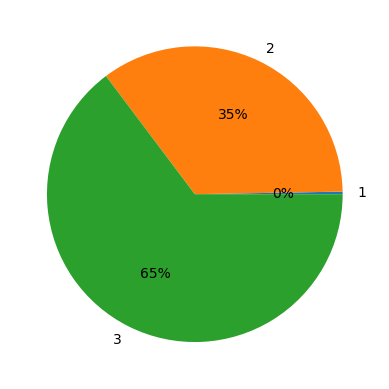

In [153]:
n_gram_count = Counter(non_unigrams_counter['ngram_len'].values)
plt.pie(n_gram_count.values(), labels = n_gram_count.keys(), autopct='%.0f%%')

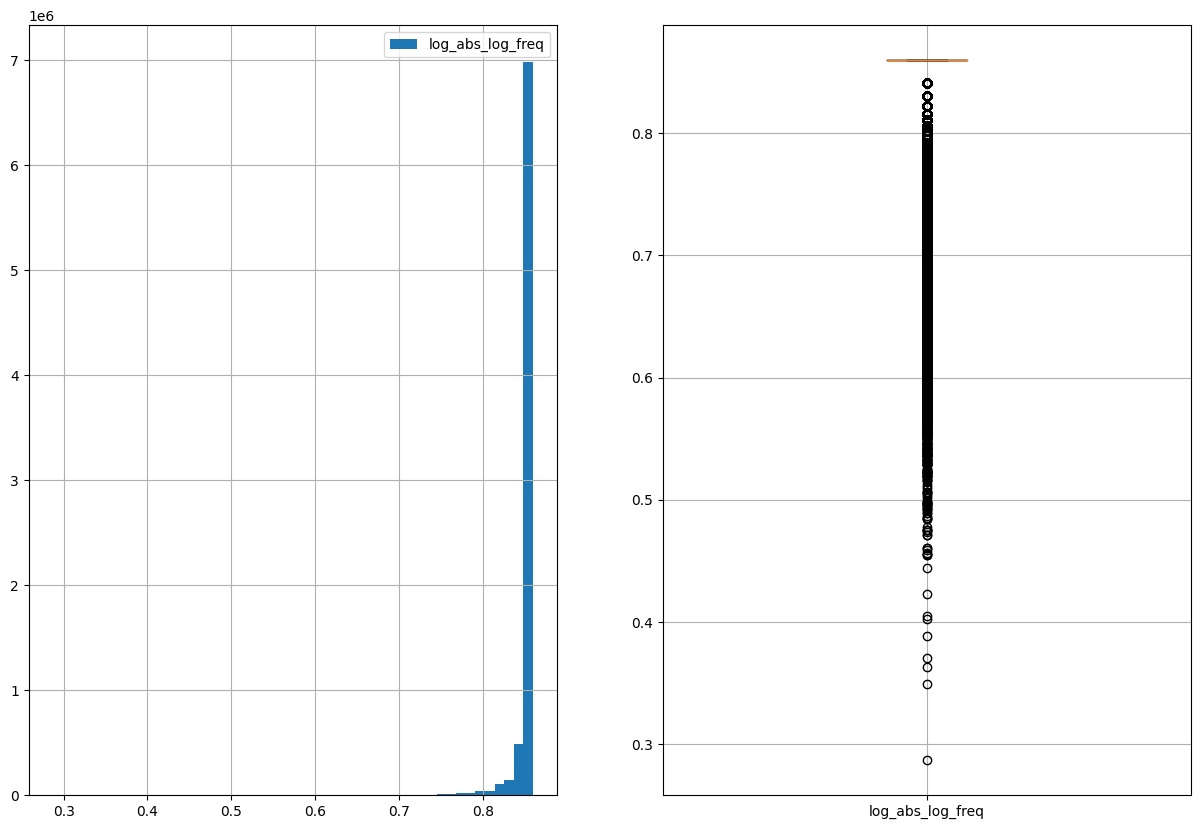

In [109]:
plot_ngram_stat(non_unigrams_counter.columns[5:], non_unigrams_counter)

In [110]:
min_threshold_count_ngram, max_threshold_count_ngram = 50, 100_000

In [111]:
ngrams_to_filter = non_unigrams_counter[(non_unigrams_counter['count'] < min_threshold_count_ngram) | (non_unigrams_counter['count'] > max_threshold_count_ngram )]
filtred_non_unigrams_counter = non_unigrams_counter.drop(ngrams_to_filter.index,axis=0, inplace=False)


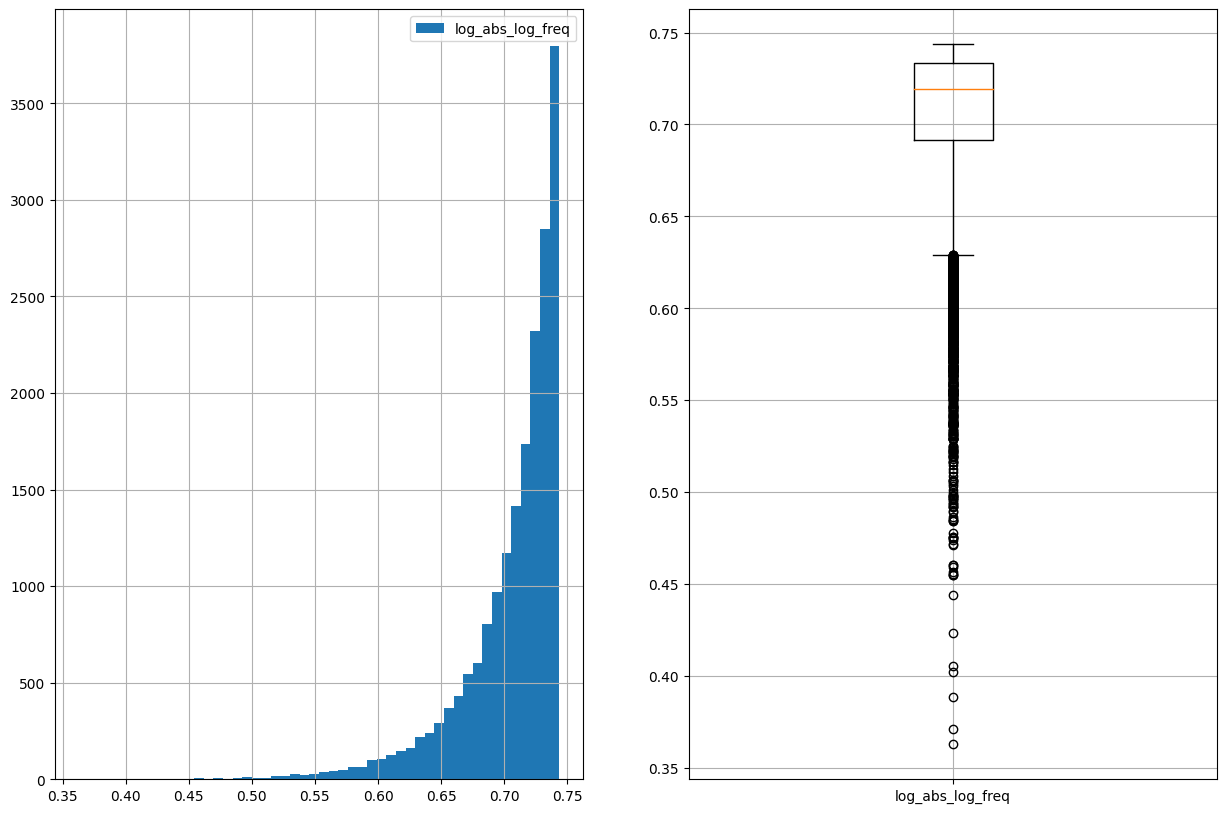

In [112]:
plot_ngram_stat(non_unigrams_counter.columns[5:], filtred_non_unigrams_counter)

In [113]:
filtred_non_unigrams_counter.describe()

,count,ngram_len,freq,log_freq,log_abs_log_freq
count,18810.000000,18810.000000,18810.000000,18810.000000,18810.000000
mean,338.060074,1.468527,0.000019,-5.100759,0.705907
std,1533.120183,0.591011,0.000088,0.429765,0.039940
min,50.000000,1.000000,0.000003,-5.542328,0.362832
25%,67.000000,1.000000,0.000004,-5.415224,0.691702
50%,101.000000,1.000000,0.000006,-5.236977,0.719081
75%,211.000000,2.000000,0.000012,-4.917016,0.733616
max,86187.000000,3.000000,0.004945,-2.305857,0.743692


([<matplotlib.patches.Wedge at 0x7f40ebaf2b60>,
 [Text(-0.2789294551684323, 1.064048099965148, '1'),
  Text(0.10858465942672899, -1.094627503645501, '2'),
  Text(1.0863852704802435, -0.17253128436190443, '3')],
 [Text(-0.15214333918278125, 0.5803898727082625, '58%'),
  Text(0.059227996050943074, -0.5970695474430004, '37%'),
  Text(0.5925737838983145, -0.0941079732883115, '5%')])

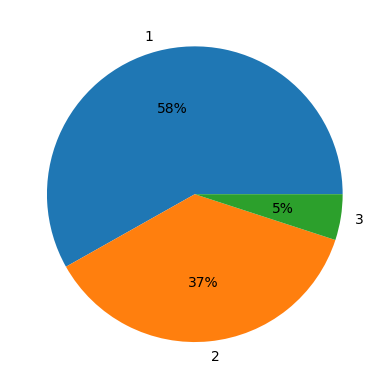

In [152]:
n_gram_count = Counter(filtred_non_unigrams_counter['ngram_len'].values)
plt.pie(n_gram_count.values(), labels = n_gram_count.keys(), autopct='%.0f%%')

In [135]:
list(filtred_non_unigrams_counter.groupby(by=['ngram_len']).agg({'freq' : len}))

['freq']

# Написание фунций обработки текстов. Токенизация текста N-gram 1-3

<ol>
    <li>Токенизация текста</li>
    <li>Отчистка от стопслов и пунктуации</li>
    <li>Выделение в текстах n-gram</li>
</ol>

In [ ]:
sys.path[0] += '/green'

In [81]:
# if __name__ == '__main__':
#     import sys
#     sys.path[0] = '/'.join(sys.path[0].split('/')[:-1])

In [95]:
# sys.path[0] = sys.path[0].replace('green_atom', '/green_atom')

In [173]:
tokens = {
    token : i for i, token in enumerate(filtred_non_unigrams_counter.sort_values('ngram')['ngram'])
}
tokens

{'<bos>': 0,
 '<bos> absolutely': 1,
 '<bos> actually': 2,
 '<bos> admit': 3,
 '<bos> agree': 4,
 '<bos> almost': 5,
 '<bos> although': 6,
 '<bos> always': 7,
 '<bos> another': 8,
 '<bos> anyone': 9,
 '<bos> awful': 10,
 '<bos> bad': 11,
 '<bos> based': 12,
 '<bos> believe': 13,
 '<bos> best': 14,
 '<bos> big': 15,
 '<bos> big fan': 16,
 '<bos> bought': 17,
 '<bos> br': 18,
 '<bos> br br': 19,
 '<bos> caught': 20,
 '<bos> could': 21,
 '<bos> definitely': 22,
 '<bos> despite': 23,
 '<bos> director': 24,
 '<bos> documentary': 25,
 '<bos> enjoyed': 26,
 '<bos> even': 27,
 '<bos> ever': 28,
 '<bos> every': 29,
 '<bos> excellent': 30,
 '<bos> fan': 31,
 '<bos> far': 32,
 '<bos> film': 33,
 '<bos> finally': 34,
 '<bos> finished': 35,
 '<bos> first': 36,
 '<bos> first let': 37,
 '<bos> first saw': 38,
 '<bos> first time': 39,
 '<bos> found': 40,
 '<bos> friend': 41,
 '<bos> funny': 42,
 '<bos> gave': 43,
 '<bos> get': 44,
 '<bos> give': 45,
 '<bos> going': 46,
 '<bos> good': 47,
 '<bos> got':

In [82]:
from dataprocess import DataPreProcesser

In [97]:
data_preprocesser = DataPreProcesser(10_000)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/argen7um/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [163]:
split_by_space = lambda a: a.split()
get_n_gram_from_seq = lambda a: list(everygrams(split_by_space(a), max_len=3))
sample_df['preprocessed text'].iloc[:10].parallel_apply(get_n_gram_from_seq)

0    [(<bos>,), (<bos>, lowbudget), (<bos>, lowbudg...
1    [(<bos>,), (<bos>, loved), (<bos>, loved, movi...
2    [(<bos>,), (<bos>, march), (<bos>, march, new)...
3    [(<bos>,), (<bos>, watched), (<bos>, watched, ...
4    [(<bos>,), (<bos>, cell), (<bos>, cell, fascin...
5    [(<bos>,), (<bos>, documentary), (<bos>, docum...
6    [(<bos>,), (<bos>, crackerjack), (<bos>, crack...
7    [(<bos>,), (<bos>, still), (<bos>, still, good...
8    [(<bos>,), (<bos>, no), (<bos>, no, not), (no,...
9    [(<bos>,), (<bos>, think), (<bos>, think, movi...
Name: preprocessed text, dtype: object

In [178]:
seq = sample_df['preprocessed text'].iloc[0]
seq = [' '.join(token) for token in get_n_gram_from_seq(seq)]

In [180]:
[tokens.get(token) for token in seq if tokens.get(token) is not None] 

[0,
 9886,
 6193,
 18665,
 7296,
 18476,
 9711,
 3026,
 1236,
 14857,
 18466,
 12746,
 11704,
 11830,
 11185,
 13935,
 4047,
 957,
 10024,
 4227,
 18471,
 1197,
 432,
 8676,
 13073,
 7886,
 2715,
 236,
 8778,
 2244,
 2543,
 14857,
 6881,
 8069,
 18676,
 1893,
 18747,
 18752,
 11704,
 3463,
 14040,
 17336,
 18497,
 4355,
 18497,
 11566,
 13477,
 9632,
 8522,
 1437,
 3168,
 10792,
 14171,
 17896,
 11348,
 10804,
 16109,
 638,
 639,
 640,
 1142,
 8956,
 1168,
 8416,
 16197,
 6172,
 6174,
 14743,
 13790,
 7989,
 7995,
 14788,
 13391,
 2860,
 2135,
 2427,
 8293,
 4642,
 14929,
 16683,
 13655,
 17418,
 14539,
 14929,
 14957,
 10810,
 12389,
 14669,
 14672,
 10712,
 10714,
 10715]

In [183]:
def preprocess_ngram(seq):
    seq = everygrams(seq.split(), max_len=3)
    return [tokens.get(' '.join(token)) for token in seq if tokens.get(' '.join(token)) is not None]    


In [189]:
sample_df['encoded text'] = sample_df['preprocessed text'].parallel_apply(preprocess_ngram)

In [191]:
sample_df

,preprocessed text,encoded text
0,<bos> lowbudget film writer goes work london c...,"[0, 9886, 6193, 18665, 7296, 18476, 9711, 3026..."
1,<bos> loved movie scenery breathtaking plot ni...,"[0, 71, 72, 9865, 9868, 10810, 14758, 2679, 13..."
2,<bos> march new york times article described c...,"[0, 10218, 11491, 11505, 18759, 17062, 1056, 4..."
3,<bos> watched pretty damn awesome fights fanta...,"[0, 161, 18082, 13300, 13304, 4271, 1234, 6181..."
4,<bos> cell fascinated first glance bit surpris...,"[0, 3094, 6032, 6567, 6579, 7230, 1756, 16431,..."
...,...,...
49995,<bos> movie apparently intended young evangeli...,"[0, 78, 10810, 955, 8575, 18761, 3349, 1168, 1..."
49996,<bos> ivan marco alexandre partners company to...,"[0, 8721, 584, 12572, 3686, 17111, 7054, 6567,..."
49997,<bos> cut film film students making film much ...,"[0, 4238, 6193, 6280, 6193, 6424, 16238, 10114..."
49998,<bos> fox fascination dysfunctional families m...,"[0, 6792, 6034, 5104, 5966, 9947, 10369, 12009..."
